In [41]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import joblib

In [3]:
# Load the dataset
df = pd.read_csv('HI-Small_Trans.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB


In [5]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [6]:
df.isnull().sum()

Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64

In [7]:
df.nunique()

Timestamp              15018
From Bank              30470
Account               496995
To Bank                15811
Account.1             420636
Amount Received       915161
Receiving Currency        15
Amount Paid           923873
Payment Currency          15
Payment Format             7
Is Laundering              2
dtype: int64

In [8]:
df[df.duplicated()==True]

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
863295,2022/09/01 16:20,12004,800C927C1,12004,800C927C0,0.000008,Bitcoin,0.080000,Euro,ACH,0
863296,2022/09/01 16:20,12004,800C927C1,220,813D8C1E1,0.000008,Bitcoin,0.000008,Bitcoin,Bitcoin,0
3684005,2022/09/07 21:25,29992,8099A29B1,220,813725AE1,0.000003,Bitcoin,0.000003,Bitcoin,Bitcoin,0
4166786,2022/09/08 21:05,113779,811144AB1,113779,811144AB0,0.000002,Bitcoin,0.020000,US Dollar,ACH,0
4166787,2022/09/08 21:05,113779,811144AB1,53744,813C777F1,0.000002,Bitcoin,0.000002,Bitcoin,Bitcoin,0
4510480,2022/09/09 10:03,6075,80C702911,6075,80C702910,0.000002,Bitcoin,0.020000,US Dollar,ACH,0
4510481,2022/09/09 10:03,6075,80C702911,154653,814389B61,0.000002,Bitcoin,0.000002,Bitcoin,Bitcoin,0
4816512,2022/09/09 21:33,14433,80935A891,14433,80935A890,0.000001,Bitcoin,0.010000,US Dollar,ACH,0
4816513,2022/09/09 21:33,14433,80935A891,15,813F7AE61,0.000001,Bitcoin,0.000001,Bitcoin,Bitcoin,0


In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [11]:
df['Hour'] = df['Timestamp'].dt.hour

In [13]:
df.drop(['Timestamp', 'From Bank', 'To Bank', 'Account', 'Account.1', 'Receiving Currency', 'Amount Received'], axis=1, inplace=True)

In [14]:
df['Is Laundering'].value_counts(normalize=True)

Is Laundering
0    0.998981
1    0.001019
Name: proportion, dtype: float64

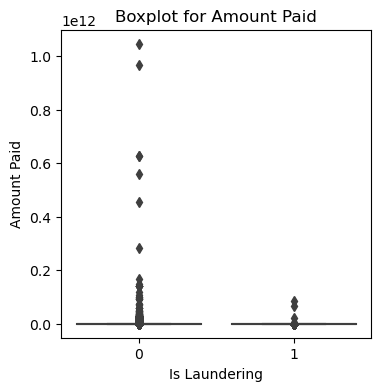

In [15]:
plt.figure(figsize=(4,4))
sns.boxplot(x='Is Laundering', y='Amount Paid', data=df)
plt.title(f'Boxplot for Amount Paid')
plt.show()

In [16]:
launder = df.groupby('Is Laundering')

In [17]:
sampledf=launder.apply(lambda x: x.sample(launder.size().min())).reset_index(drop=True)
sampledf

,Amount Paid,Payment Currency,Payment Format,Is Laundering,Hour
0,7705.10,Saudi Riyal,Credit Card,0,5
1,33.32,Euro,Credit Card,0,12
2,166.83,US Dollar,Cheque,0,1
3,18034.27,US Dollar,Credit Card,0,18
4,349.98,Shekel,Wire,0,20
...,...,...,...,...,...
10349,6101.07,US Dollar,ACH,1,13
10350,7142.46,Euro,ACH,1,12
10351,4517.63,Euro,Cheque,1,8
10352,15243.47,Yuan,ACH,1,0


In [18]:
sampledf = sampledf.sample(n=1000,random_state=1)

In [22]:
sampledf['Is Laundering'].value_counts(normalize=True)

Is Laundering
0    0.516
1    0.484
Name: proportion, dtype: float64

In [24]:
sampledf.describe()

,Amount Paid,Is Laundering,Hour
count,1.000000e+03,1000.000000,1000.000000
mean,6.890077e+07,0.484000,11.271000
std,2.100382e+09,0.499994,6.660475
min,7.910000e-04,0.000000,0.000000
25%,5.763800e+02,0.000000,6.000000
50%,3.959565e+03,0.000000,12.000000
75%,1.654967e+04,1.000000,17.000000
max,6.641449e+10,1.000000,23.000000


In [25]:
for col in sampledf.select_dtypes(exclude=['number']).columns:
        print(col,sampledf[col].unique())

Payment Currency ['Shekel' 'UK Pound' 'US Dollar' 'Euro' 'Bitcoin' 'Saudi Riyal' 'Rupee'
 'Canadian Dollar' 'Yen' 'Swiss Franc' 'Ruble' 'Australian Dollar' 'Yuan'
 'Brazil Real' 'Mexican Peso']
Payment Format ['ACH' 'Bitcoin' 'Cash' 'Cheque' 'Credit Card' 'Wire' 'Reinvestment']


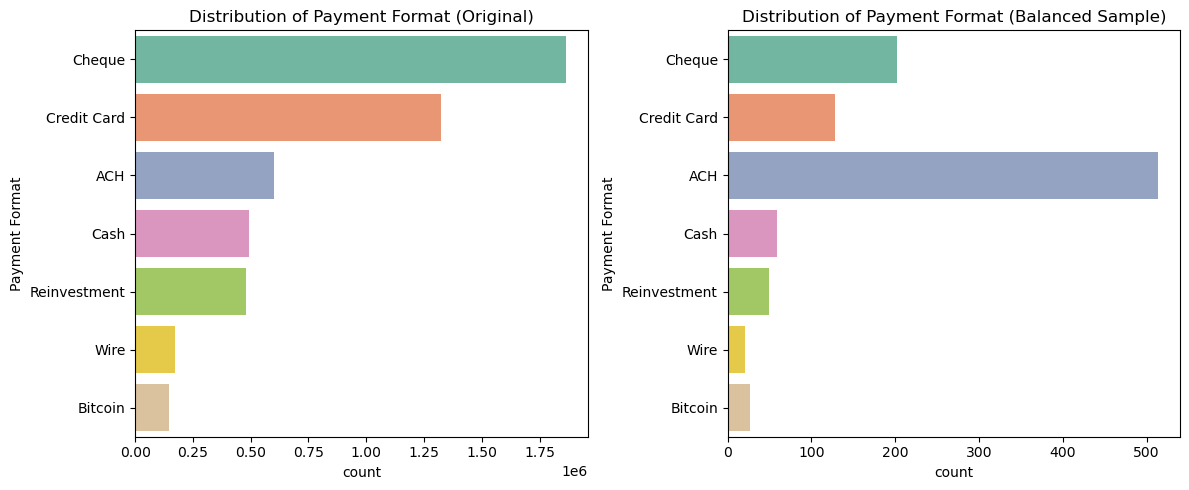

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

order = df['Payment Format'].value_counts().index
sns.countplot(y='Payment Format', data=df, ax=ax1, palette='Set2', order=order)
ax1.set_title('Distribution of Payment Format (Original)')

sns.countplot(y='Payment Format', data=sampledf, ax=ax2, palette='Set2', order=order)
ax2.set_title('Distribution of Payment Format (Balanced Sample)')

plt.tight_layout()
plt.show()

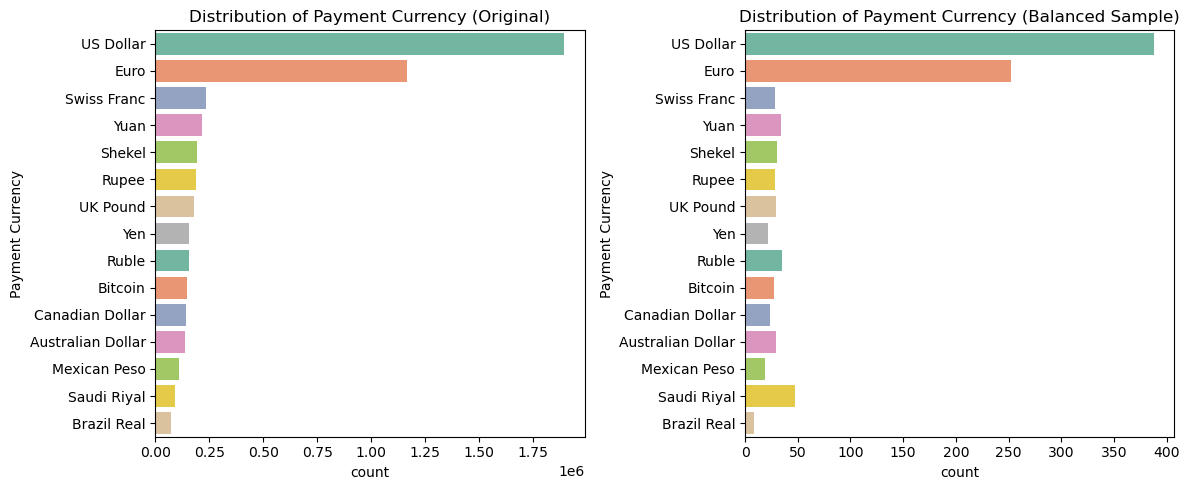

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

order = df['Payment Currency'].value_counts().index
sns.countplot(y='Payment Currency', data=df, ax=ax1, palette='Set2', order=order)
ax1.set_title('Distribution of Payment Currency (Original)')

sns.countplot(y='Payment Currency', data=sampledf, ax=ax2, palette='Set2', order=order)
ax2.set_title('Distribution of Payment Currency (Balanced Sample)')

plt.tight_layout()
plt.show()

In [28]:
sampledf_encoded = pd.get_dummies(sampledf, dtype=int)
sampledf_encoded

,Amount Paid,Is Laundering,Hour,Payment Currency_Australian Dollar,Payment Currency_Bitcoin,Payment Currency_Brazil Real,Payment Currency_Canadian Dollar,Payment Currency_Euro,Payment Currency_Mexican Peso,Payment Currency_Ruble,...,Payment Currency_US Dollar,Payment Currency_Yen,Payment Currency_Yuan,Payment Format_ACH,Payment Format_Bitcoin,Payment Format_Cash,Payment Format_Cheque,Payment Format_Credit Card,Payment Format_Reinvestment,Payment Format_Wire
9964,2.811407e+04,1,18,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9483,1.056100e+02,1,21,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
891,1.418399e+06,0,20,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
8452,1.258233e+04,1,12,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
448,2.863000e-03,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,4.739800e+02,0,8,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
5890,9.067310e+03,1,12,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2657,7.183700e+02,0,16,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1410,2.034100e+02,0,21,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


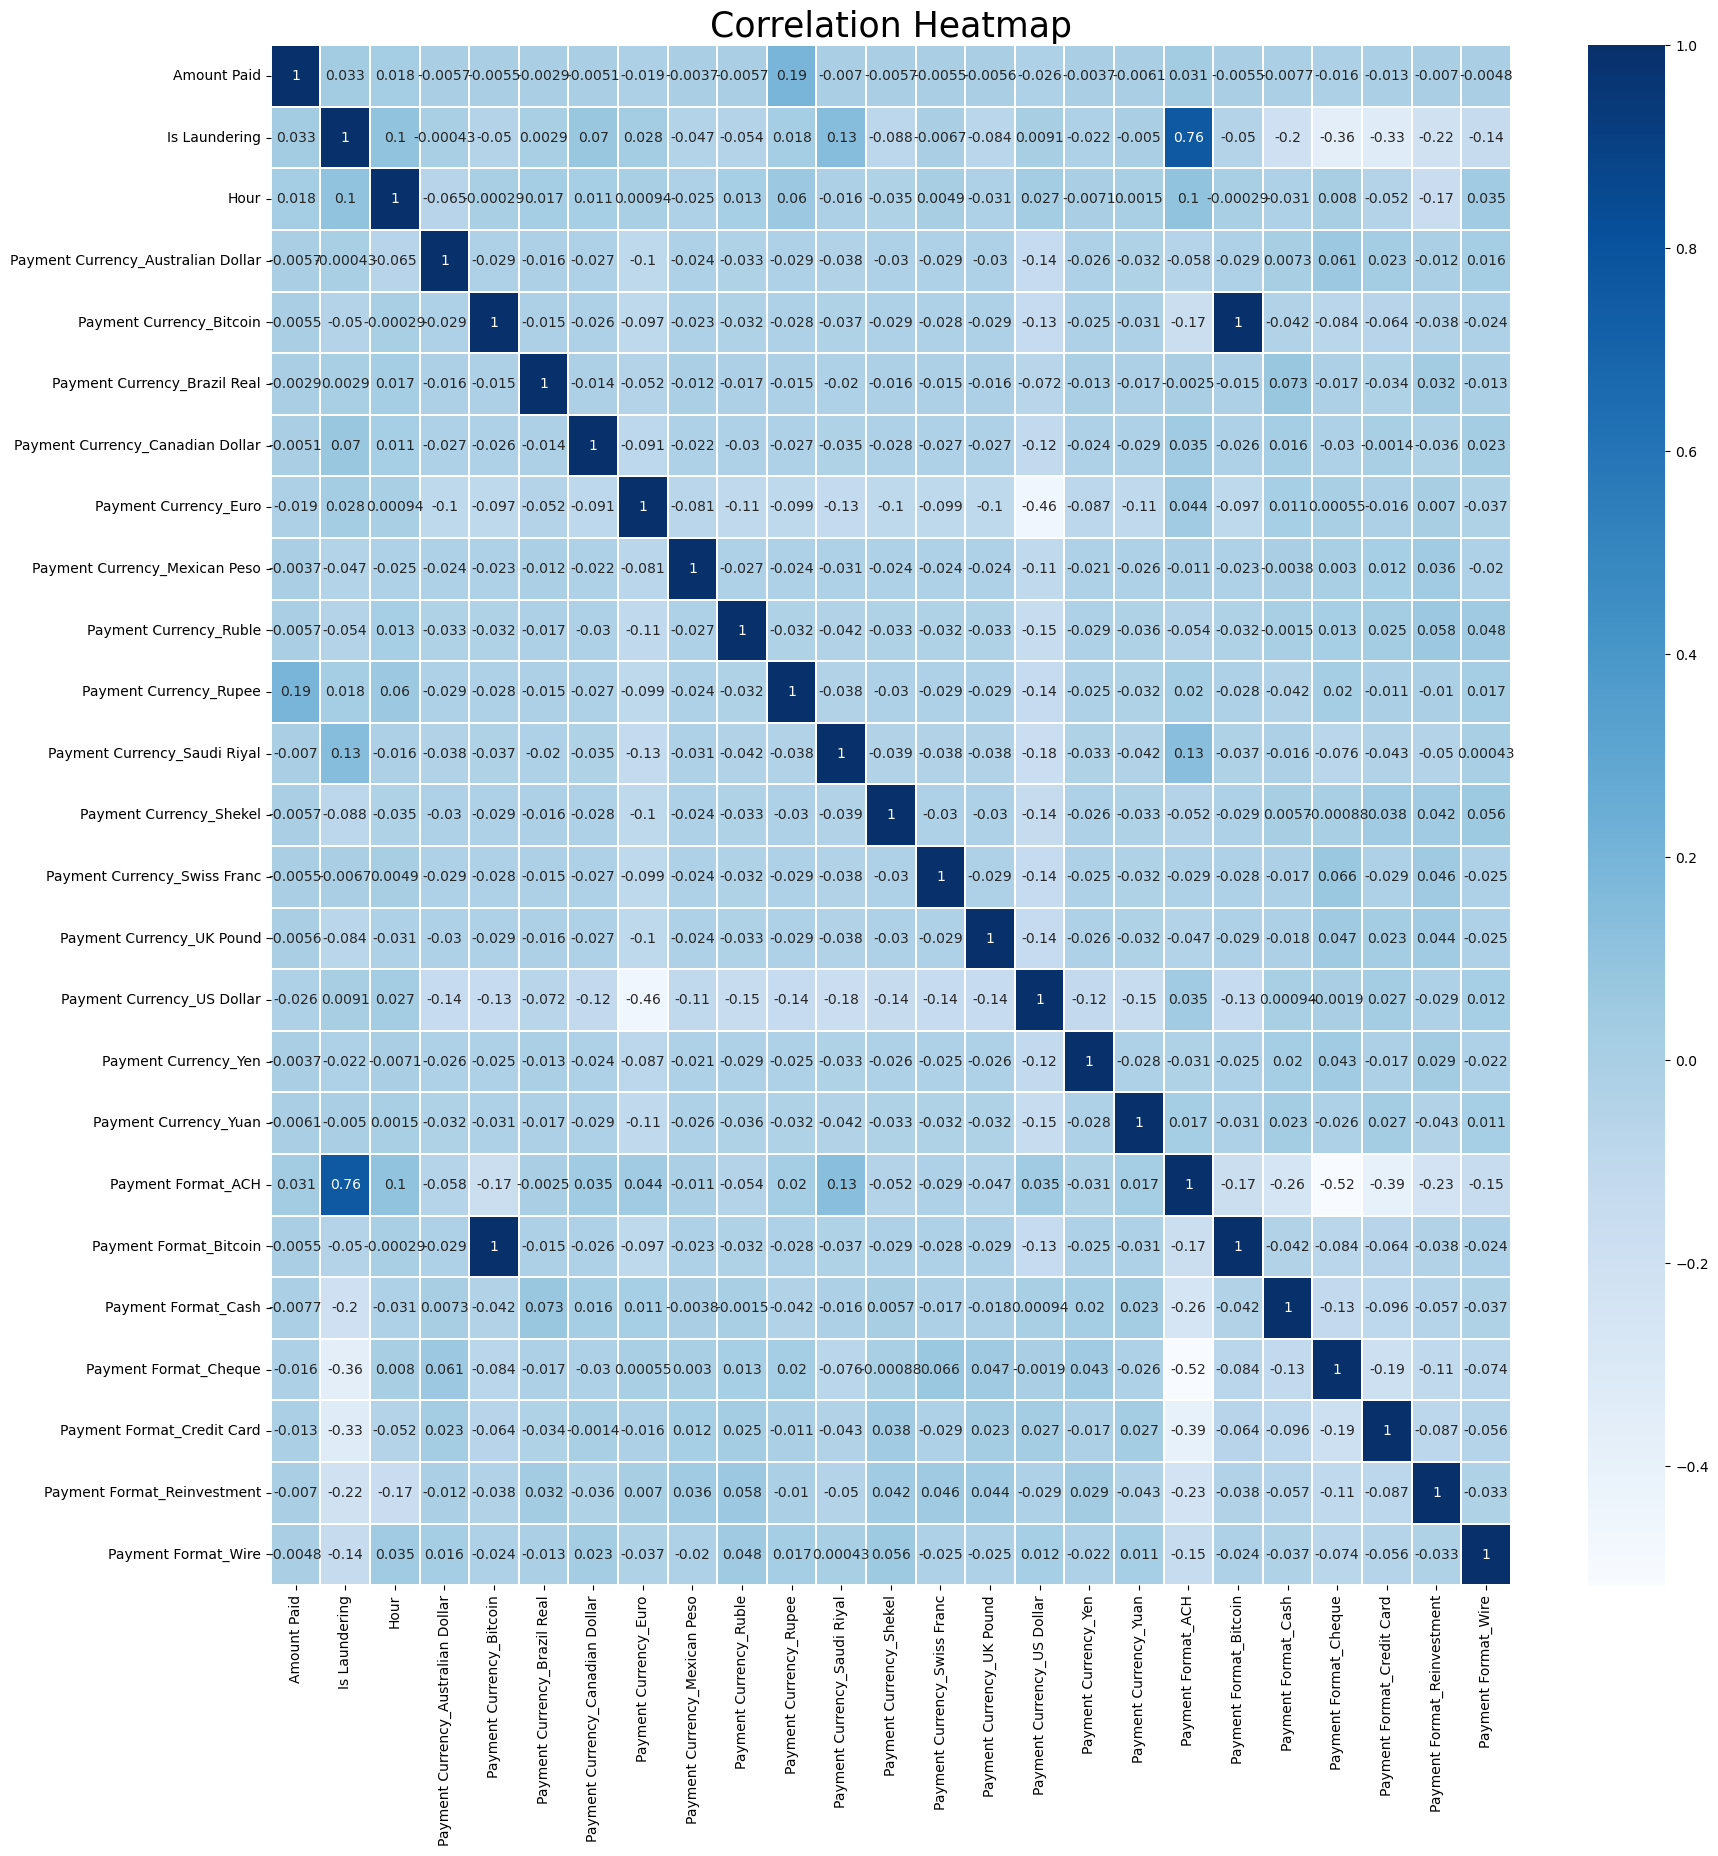

In [29]:
plt.figure(figsize=(20,20));
sns.heatmap(sampledf_encoded.corr(),annot=True,cmap='Blues',linewidth=0.01);
plt.title('Correlation Heatmap',fontsize=25,fontweight=5);

In [30]:
df[(df['Payment Currency']=='Bitcoin') & (df['Payment Format']!='Bitcoin')]['Is Laundering'].value_counts()

Is Laundering
0    53
Name: count, dtype: int64

In [31]:
sampledf_encoded.drop(['Payment Currency_Bitcoin'], axis=1, inplace=True)

In [32]:
X = sampledf_encoded.drop(['Is Laundering'],axis=1)
y = sampledf_encoded['Is Laundering']

In [33]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [34]:
X.dtypes

Amount Paid                           float64
Hour                                    int32
Payment Currency_Australian Dollar      int32
Payment Currency_Brazil Real            int32
Payment Currency_Canadian Dollar        int32
Payment Currency_Euro                   int32
Payment Currency_Mexican Peso           int32
Payment Currency_Ruble                  int32
Payment Currency_Rupee                  int32
Payment Currency_Saudi Riyal            int32
Payment Currency_Shekel                 int32
Payment Currency_Swiss Franc            int32
Payment Currency_UK Pound               int32
Payment Currency_US Dollar              int32
Payment Currency_Yen                    int32
Payment Currency_Yuan                   int32
Payment Format_ACH                      int32
Payment Format_Bitcoin                  int32
Payment Format_Cash                     int32
Payment Format_Cheque                   int32
Payment Format_Credit Card              int32
Payment Format_Reinvestment       

In [35]:
scaler = RobustScaler()

numeric_cols = X.select_dtypes(include=['int32','float64']).columns 
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [36]:
# Define the model
gbc = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Train the model
gbc.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, random_state=42)

Test Accuracy: 0.88
Test Precision: 0.865979381443299
Test Recall: 0.8842105263157894
Test F1 Score: 0.8749999999999999
Confusion Matrix:
[[92 13]
 [11 84]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       105
           1       0.87      0.88      0.87        95

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200



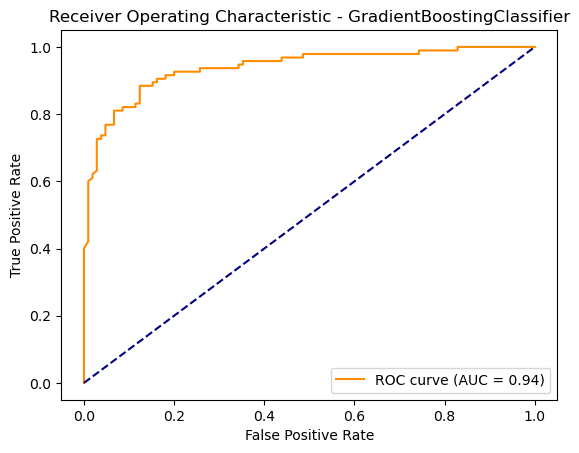

In [39]:
# Predict on the test data
y_pred = gbc.predict(X_test)
y_pred_prob = gbc.predict_proba(X_test)[:, 1]

# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1 Score: {f1}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label=f'ROC curve (AUC = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - GradientBoostingClassifier')
plt.legend(loc='lower right')
plt.show()


In [42]:
# Save the trained model
joblib.dump(gbc, 'gbc_aml_model.pkl')

['gbc_aml_model.pkl']